In [6]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
import seaborn as sns
from sklearn.linear_model import LinearRegression

### About this dataset

This data comes courtesy of OECD and shows historical population data broken down by sex and age for the 56 members of the OECD

Citation:

OECD (2021), "Labour Force Statistics: Historical population data", OECD Employment and Labour Market Statistics (database), https://doi.org/10.1787/4cf3d106-en (accessed on 21 October 2021).

In [7]:
#import and clean dataset
pd.options.display.float_format = '{:,.2f}'.format
countries_data = pd.read_csv("/raw_data/HISTPOP_21102021122126731.csv")
pop_data = countries_data.groupby(by=["Country", "Time", "Sex", "Age"]).sum().reset_index(drop=False)
pop_data = pop_data[pop_data.Age.str.contains(pat="^\w{1,2} to \w{1,4}$|85 and over|^Total$")]
Age_labels = pop_data.Age.unique().tolist()
Age_labels.insert(1, Age_labels.pop(11))
Age_labels.remove("15 to 64")
Age_labels.remove("20 to 64")
pop_data = pop_data[pop_data.Age.str.contains("|".join(Age_labels))]
pop_data.drop(columns=["TIME", "Flag Codes", "Flags"], inplace=True)
pop_data.rename({"Time": "Year", "Value": "Population"}, axis=1, inplace=True)
pop_data.sort_values(by=["Year", "Age", "Population"], inplace=True, ascending=True)
pop_data.reset_index(drop=True, inplace=True)


In [8]:
#create country class 

class Country():
  
  def __init__(self, name):
    self.name = name

  def country_pop_profile(self):
    """
    Returns a dataframe with population data for the country
    """
    country_data = pop_data[pop_data["Country"] == self.name].reset_index(drop=True)

    return country_data
  
  def chart_pop_growth(self, by_sex=False, as_line=False):
    """
    Plots total population over time, providing an idea of how numbers have changed
    Add the argument by_sex=True to see a breakdown by sex
    If a line chart is preferred add the argument as_line=True
    """
    fig, ax, = plt.subplots(figsize=(10,6))
    data = self.country_pop_profile()
    if by_sex == False:
      total_pop = data[(data.Sex == "Total") & (data.Age == "Total")]
      min_pop = min(data.Population[(data.Sex == "Total") & (data.Age == "Total")]) * 0.98
      max_pop = max(data.Population[(data.Sex == "Total") & (data.Age == "Total")]) * 1.02
      if as_line == False:
        sns.barplot(data=total_pop, x="Year", y="Population", ax=ax, palette='Set2')
      else:
        sns.lineplot(data=total_pop, x="Year", y="Population", ax=ax)
      ax.ticklabel_format(style="plain", axis="y")
      ax.set_ylim(min_pop, max_pop)
      ax.set_title(f'{self.name} Population over time: 2005 - 2020')
      ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    elif by_sex == True:
      sex_pop = data[(data.Age == "Total")]
      if as_line == False:
        sns.barplot(data=sex_pop, x="Year", y="Population", hue="Sex", ax=ax, palette='bright')
      else:
        sns.lineplot(data=sex_pop, x="Year", y="Population", hue="Sex", ax=ax)

      ax.ticklabel_format(style="plain", axis="y")
      ax.set_title(f'{self.name} Population over time by sex: 2005 - 2020')
      ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    

    plt.show()

  def chart_pop_by_age(self, years=None, by_sex=False):
    """
    Plots barcharts for populations by age and sex for years 2005 - 2020
    If specific years are desired these can be included in a list as an argument (e.g. [2005, 2010, 2020])
    If a breakdown by sex is required, add the argument by_sex = True
    """
    data = self.country_pop_profile()

    if years != None:
      data = data[(data["Year"].isin(years)) & (~data["Age"].str.contains('Total')) & (data["Sex"] != 'Total')]
    else:
      data = data[(~data["Age"].str.contains('Total')) & (data["Sex"] != 'Total')]
    
    age_order = data.Age.unique().tolist()
    age_order.insert(1, age_order.pop(9))

    if by_sex == True:
      g = sns.catplot(kind="bar", data=data, x="Age", y="Population", hue="Sex", col="Year", col_wrap=3, height=5, aspect=1, order=age_order, sharex=False, sharey=False, palette="bright", legend=False)
      g.fig.suptitle(f"Population by Age & Sex - {self.name}", x=0, y=1, fontsize=16)
    else:
      g = sns.catplot(kind="bar", data=data, x="Age", y="Population", col="Year", col_wrap=3, height=5, aspect=1.2, order=age_order, sharex=False, sharey=False, palette="bright", ci=None)

    g.fig.suptitle(f"Population by Age - {self.name}", x=0, y=1, fontsize=16)
    g.set_titles("Population by Age for {col_name}")
    g.set_xticklabels(labels=age_order, rotation=90, ha='center')
    g.fig.tight_layout(pad=1, w_pad=4)

    for ax in g.axes:
      ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
      if by_sex == True:
        ax.legend()
      else:
        pass
    
    plt.show()
      
  def growth_trend(self, max_year=2050):
    """
    Plots linegraph of population over time with projections up to 2050.
    The length of projection can be set by setting the max_year argument to the value of your choice
    """
    data = self.country_pop_profile()
    totals = data[(data.Age == 'Total') & (data.Sex == 'Total')].reset_index(drop=True)
    totals.drop(['Sex', 'Age'], inplace=True, axis=1)

    X = totals.Year.values.reshape(-1,1)
    y = totals.Population.values

    reg = LinearRegression().fit(X,y)
    y_preds = reg.predict(X)
    X_future = np.array([x for x in range(2020, (max_year+1))]).reshape(-1,1)
    y_future = reg.predict(X_future)

    future_df = pd.DataFrame({'year': X_future.ravel(), 'predicted population': y_future.ravel()})
    df = pd.DataFrame({'year':X.ravel(), 'real population':y.ravel(), 'predicted population':y_preds.ravel()})

    
    
    melt = pd.melt(df, id_vars='year', var_name='real/pred', value_name='population')
    sns.set_style(style='darkgrid')
    fig, ax = plt.subplots(figsize=(10,6))
    sns.lineplot(data=melt, x='year', y='population', style='real/pred', ax=ax, linewidth=2, alpha=0.4)
    sns.lineplot(data=future_df, x='year', y='predicted population', linestyle='dashed', label='future prediction', linewidth=2, alpha=0.4)
    ax.set_title(f'Population and Predicted Growth in {self.name} 2005 - {max_year}')
    plt.tight_layout()
    ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.legend(title='')
    ax.axvline(x=2020, color='black', linestyle='dotted')
    plt.show()

    
    

    


uk = Country("United Kingdom")



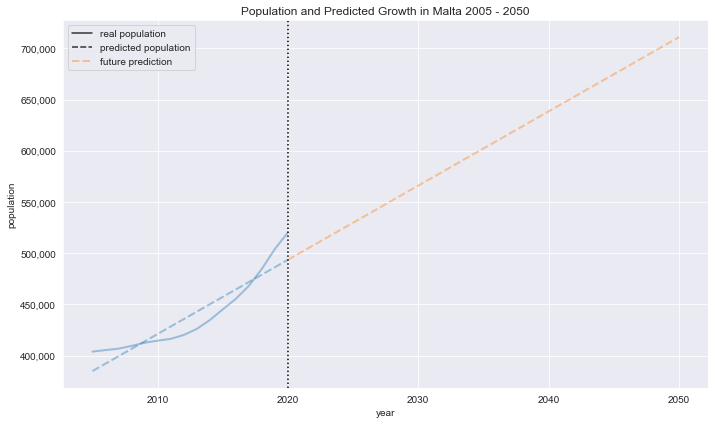

In [9]:
germany = Country("Germany")
uk = Country("United Kingdom")
usa = Country("United States")
japan = Country('Japan')
malta = Country('Malta')

malta.growth_trend()